In [146]:
import random
import re
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency, pearsonr, rv_discrete
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression, Ridge, SGDClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import (RandomizedSearchCV, cross_val_predict,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from tqdm.notebook import tqdm

In [2]:
pd.options.mode.chained_assignment = None

set_config(enable_metadata_routing=True)

np.seterr(invalid='ignore')

random_seed = 42
random.seed(random_seed)

main_path = Path.cwd() / ".."
df = pd.read_csv(main_path / "data/weatherAUS.csv")

spectral_palette = [
    "#9e0142",
    "#d53e4f",
    "#f46d43",
    "#fdae61",
    "#fee08b",
    "#ffffbf",
    "#e6f598",
    "#abdda4",
    "#66c2a5",
    "#3288bd",
    "#5e4fa2",
]

---

#### Data cleansing

Eliminamos las observaciones sin ground truth en la variable objetivo, ya que no van a ser necesarias para el entrenamiento (debido a la gran cantidad de observaciones con las que contamos y la relativamente baja proporción de datos faltantes en la variable objetivo), y tampoco nos van a ser útiles para evaluar el modelo ya que en la immputación podemos introducir ciertos sesgos.

In [3]:
print(
    f"Proporción de datos faltantes en la variable objetivo: {round(df.RainTomorrow.isna().mean(), 3)}"
)

Proporción de datos faltantes en la variable objetivo: 0.022


In [4]:
df = df.dropna(subset=["RainTomorrow"])

---

#### Categorical features encoding

##### Rain Today and Rain Tomorrow

In [5]:
rain_columns = ["RainToday", "RainTomorrow"]
mapping_dict = {"Yes" : 1, "No" : 0}

for column in rain_columns:
    df[column] = df[column].map(mapping_dict)

##### Location

In [6]:
# Geolocate stations
country = "Australia"

mapping_dict = {"Dartmoor": "DartmoorVillage", "Richmond": "RichmondSydney"}
df["Location"] = df["Location"].map(mapping_dict).fillna(df["Location"])

locations = df["Location"].unique()
locations = [re.sub(r"([a-z])([A-Z])", r"\1 \2", l) for l in locations]

locs = []
lats = []
lons = []
for location in locations:
    try:
        lat, lon = ox.geocode(location + f", {country}")

        locs.append(location.replace(" ", ""))
        lats.append(lat)
        lons.append(lon)
    except Exception as e:
        print(f"Error retrieving coordinates for {location}: {e}")

df_locations = pd.DataFrame({"Location": locs, "Lat": lats, "Lon": lons})

df = pd.merge(df, df_locations, how="left", on="Location")

##### Date

In [7]:
df["Date"] = pd.to_datetime(df["Date"])

df['DayOfYear'] = df['Date'].dt.dayofyear
df['DaysInYear'] = df['Date'].dt.is_leap_year.apply(lambda leap: 366 if leap else 365)

df['Angle'] = 2 * np.pi * (df['DayOfYear'] - 1) / (df['DaysInYear'])

df['DayCos'] = np.cos(df['Angle'])
df['DaySin'] = np.sin(df['Angle'])

df = df.drop(columns=["DayOfYear", "DaysInYear", "Angle"])

##### Wind Dir

In [8]:
dirs = ["E", "ENE", "NE", "NNE", "N", "NNW", "NW", "WNW", "W", "WSW", "SW", "SSW", "S", "SSE", "SE", "ESE"]
angles = np.radians(np.arange(0, 360, 22.5))
mapping_dict = {d: a for (d, a) in zip(dirs, angles)}

wind_dir_columns = ["WindGustDir", "WindDir9am", "WindDir3pm"]
for column in wind_dir_columns:
    df[f"{column}Angle"] = df[column].map(mapping_dict)

    df[f"{column}Cos"] = np.cos(df[f"{column}Angle"])
    df[f"{column}Sin"] = np.sin(df[f"{column}Angle"])

    df = df.drop(columns=f"{column}Angle")

---

#### Train Test split

Vamos a utilizar una proporción de 0.7|0.15|0.15 para train, validation and test sets respectivamente. Este split no vamos a realizarlo seleccionadas observaciones completamente al azar, sino que por el contrario vamos a considerar todas las observaciones correspondientes a una serie de fechas seleccionadas al azar. Esto nos permitirá evitar el fenómeno de data leaking dado por un modelo que aprenda que en un determinado día y en un determinado sector geográfico hay lluvia al día siguiente (positivo para la clase objetivo) a partir de observaciones para el mismo día en estaciones cercanas entre si. Recordemos que, cómo vimos en el análisis exploratorio de datos, encontramos estaciones meteorológicas muy cercanas entre si con correlaciones cercanas a 0.8 para la probabilidad de lluvia en un mismo día.

In [9]:
def split_list(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("The sum of the split ratios must be 1.0")
    
    random.shuffle(data)

    total_size = len(data)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    
    train_set = data[:train_size]
    val_set = data[train_size:(train_size + val_size)]
    test_set = data[(train_size + val_size):]
    
    return train_set, val_set, test_set

In [10]:
list_dates = df["Date"].unique().tolist()
train_dates, val_dates, test_dates = split_list(list_dates)

train_filt = df["Date"].isin(train_dates + val_dates)
train_set = df.loc[train_filt, :].reset_index(drop=True)

test_filt = df["Date"].isin(test_dates)
test_set = df.loc[test_filt, :].reset_index(drop=True)

---

#### Numeric skeweness reduction

In [11]:
train_set_skew = train_set.copy()

numeric_columns = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm"
]

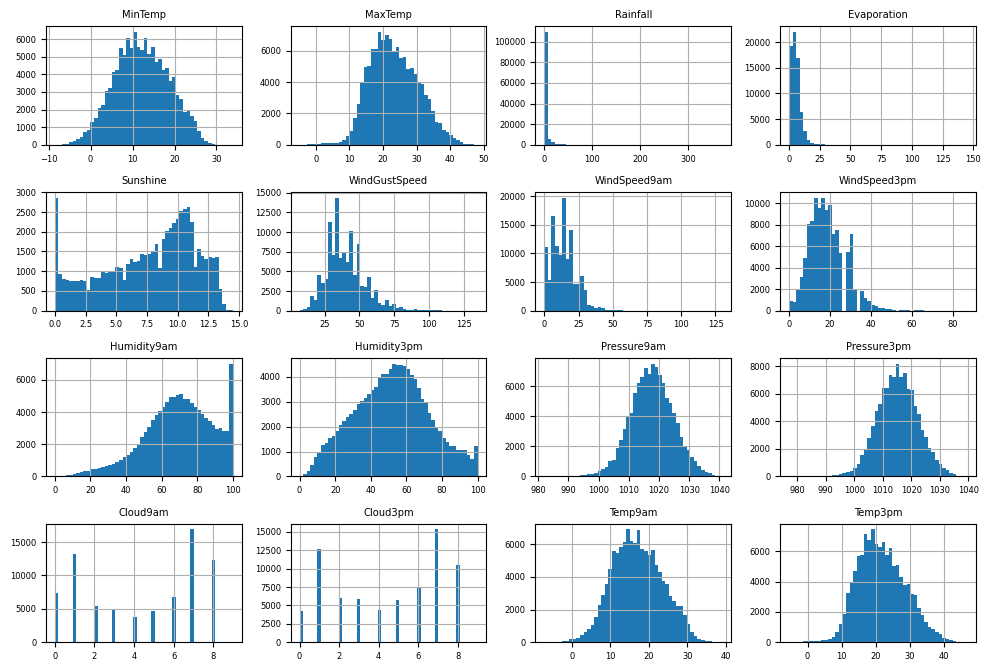

In [12]:
plt.rcParams.update({'font.size': 6})
train_set_skew[numeric_columns].hist(bins=50, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.25)
plt.show()

In [13]:
train_set_skew[numeric_columns].kurtosis(numeric_only=True)

MinTemp           -0.489722
MaxTemp           -0.237807
Rainfall         185.446037
Evaporation       47.464434
Sunshine          -0.825532
WindGustSpeed      1.409267
WindSpeed9am       1.206857
WindSpeed3pm       0.770985
Humidity9am       -0.045800
Humidity3pm       -0.516242
Pressure9am        0.226843
Pressure3pm        0.107626
Cloud9am          -1.542493
Cloud3pm          -1.458780
Temp9am           -0.349470
Temp3pm           -0.145123
dtype: float64

_Cabe remarcar, que la oblicuidad de la variable Rainfall se debe principalmente al desbalanceo del dataset (mayor cantidad de observaciones con clase negativa para las variables RainToday y RainTomorrow) y la relación determinística entre esta variable cuando asume valor 0 y un valor negativo para la variable RainToday._

Vamos a utilizar la función logarítmica en las variables "Rainfall" y "Evaporation" cuya métrica de oblicuidad es mayor a 2.

In [14]:
right_skewed_columns = ["Rainfall", "Evaporation"]
for column in right_skewed_columns:
    train_set_skew[f"{column}Log"] = np.log(train_set_skew[column]+1)

---

#### Numeric outliers handling

In [15]:
train_set_outliers = train_set_skew.copy()

numeric_columns = [
    "MinTemp",
    "MaxTemp",
    "RainfallLog",
    "EvaporationLog",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm"
]

In [16]:
def get_outlier_thresh (x, q1=0.25, q3=0.75) :
    quartile1 = x.quantile(q1)
    quartile3 = x.quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return (low_limit, up_limit)

def cap_outliers(x, limits):
    low_limit , up_limit = limits

    is_over_limits = x > up_limit
    x[is_over_limits] = up_limit

    is_under_limits = x < low_limit
    x[is_under_limits] = low_limit

    return x

In [17]:
feature_outliers_thresh = {}
for feature in tqdm(numeric_columns):
    limits = get_outlier_thresh(train_set_outliers[feature])
    train_set_outliers[feature] = cap_outliers(train_set_outliers[feature], limits)

    feature_outliers_thresh[feature] = limits

  0%|          | 0/16 [00:00<?, ?it/s]

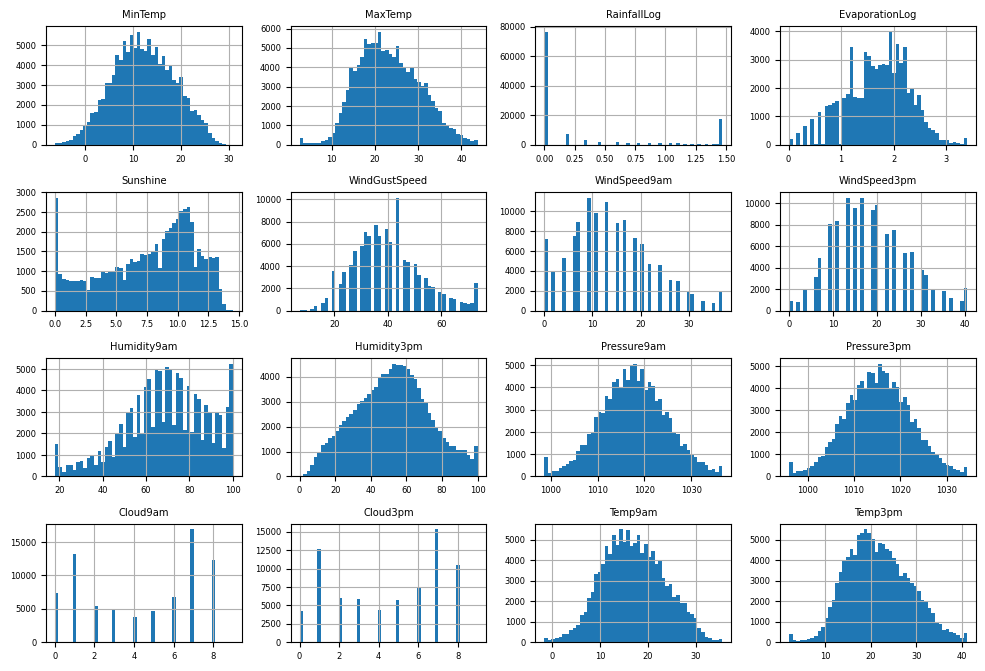

In [18]:
plt.rcParams.update({'font.size': 6})
train_set_outliers[numeric_columns].hist(bins=50, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.25)
plt.show()

---

#### Missing values imputation

Vamos a realizar la imputación de datos faltantes mediante un kn customizado utilizando las observaciones en la misma fecha y en la estación meteorológica con mayor similaridad a un dato faltante.

In [19]:
train_set_missing = train_set_outliers.copy()

index_columns = ["Date", "Location"]

feature_columns = [
    "Lat",
    "Lon",
    "DayCos",
    "DaySin",
    "MinTemp",
    "MaxTemp",
    "RainfallLog",
    "EvaporationLog",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "WindGustDirCos",
    "WindGustDirSin",
    "WindDir9amCos",
    "WindDir9amSin",
    "WindDir3pmCos",
    "WindDir3pmSin",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm",
    "RainToday",
]

target_column = ["RainTomorrow"]

In [20]:
significance_thresh = 0.05
corr_thresh = 0.7

locations = df["Location"].unique()
location_pairs = list(combinations(locations, 2))

numeric_feature_columns = [
    x
    for x in feature_columns
    if x not in ["Lat", "Lon", "DayCos", "DaySin"]
]

spatial_correlations = {}
for feature in tqdm(numeric_feature_columns):
    df_feature = train_set_missing.pivot(
        index="Date", columns="Location", values=feature
    )

    feature_correlations = []
    for location_pair in location_pairs:
        loc_a, loc_b = location_pair
        df_feature_pair = df_feature[[loc_a, loc_b]].dropna().reset_index(drop=True)
        if not df_feature_pair.empty:
            if feature=="RainToday":
                cm = pd.crosstab(df_feature_pair[loc_a], df_feature_pair[loc_b])
                chi2, pvalue, _, _ = chi2_contingency(cm)
                phi = np.sqrt(chi2 / cm.sum().sum())

                if (pvalue < significance_thresh) & (corr > corr_thresh):
                    pair_correlation = {}
                    pair_correlation["loc_a"] = loc_a
                    pair_correlation["loc_b"] = loc_b
                    pair_correlation["corr"] = phi
                    pair_correlation["intercept"] = 0
                    pair_correlation["slope"] = 1
                    feature_correlations.append(pair_correlation.copy())

                    pair_correlation["loc_a"] = loc_b
                    pair_correlation["loc_b"] = loc_a
                    feature_correlations.append(pair_correlation.copy())

            else:
                corr, pvalue = pearsonr(df_feature_pair[loc_a], df_feature_pair[loc_b])

                if (pvalue < significance_thresh) & (corr > corr_thresh):
                    ridge = Ridge(alpha=1.0)
                    ridge.fit(
                        df_feature_pair[loc_a].values.reshape(-1, 1), df_feature_pair[loc_b]
                    )
                    intercept = ridge.intercept_
                    coeficient = ridge.coef_[0]

                    pair_correlation = {}
                    pair_correlation["loc_a"] = loc_a
                    pair_correlation["loc_b"] = loc_b
                    pair_correlation["corr"] = corr
                    pair_correlation["intercept"] = intercept
                    pair_correlation["slope"] = coeficient
                    feature_correlations.append(pair_correlation.copy())

                    pair_correlation["loc_a"] = loc_b
                    pair_correlation["loc_b"] = loc_a
                    pair_correlation["intercept"] = -1 * intercept / coeficient
                    pair_correlation["slope"] = 1 / coeficient
                    feature_correlations.append(pair_correlation.copy())

    if len(feature_correlations) > 0:
        df_feature_correlations = pd.DataFrame(feature_correlations)
    else:
        df_feature_correlations = pd.DataFrame(
            None, columns=["loc_a", "loc_b", "corr", "intercept", "slope"]
        )
    spatial_correlations[feature] = df_feature_correlations

temporal_correlations = {}
for feature in tqdm(numeric_feature_columns):
    df_feature = train_set_missing.pivot(
        index="Date", columns="Location", values=feature
    )

    feature_correlations = []
    for location in locations:
        df_feature_location = df_feature[[location]]
        df_feature_location[f"{location}Before"] = df_feature_location[location].shift(
            1
        )

        df_feature_location = df_feature_location.reset_index()
        filt = (
            df_feature_location["Date"] - df_feature_location["Date"].shift(1)
        ) == pd.Timedelta("1 day")
        df_feature_location = (
            df_feature_location.loc[filt, :].dropna().reset_index(drop=True)
        )

        if not df_feature_location.empty:
            corr, pvalue = pearsonr(
                df_feature_location[location], df_feature_location[f"{location}Before"]
            )

            if (pvalue < significance_thresh) & (corr > corr_thresh):
                location_correlation = {}
                location_correlation["loc"] = location
                location_correlation["corr"] = corr
                location_correlation["intercept"] = 0
                location_correlation["slope"] = 1
                feature_correlations.append(location_correlation.copy())

    if len(feature_correlations) > 0:
        df_feature_correlations = pd.DataFrame(feature_correlations)
    else:
        df_feature_correlations = pd.DataFrame(
            None, columns=["loc", "corr", "intercept", "slope"]
        )
    temporal_correlations[feature] = df_feature_correlations

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [21]:
def impute_missing(
    df, date, location, feature, spatial_correlations, temporal_correlations, k=3
):
    filt = spatial_correlations["loc_b"] == location
    spatial_correlations = spatial_correlations.loc[filt, :]
    filt = (
        (df["Date"] == date)
        & (df["Location"].isin(spatial_correlations["loc_a"]))
        & (~df[feature].isna())
    )
    df_nearests_spatial = df.loc[filt, :]

    filt = temporal_correlations["loc"] == location
    temporal_correlations = temporal_correlations.loc[filt, :]
    filt = (
        (
            (df["Date"] == date - pd.Timedelta("1 day"))
            | (df["Date"] == date + pd.Timedelta("1 day"))
        )
        & (df["Location"].isin(temporal_correlations["loc"]))
        & (~df[feature].isna())
    )
    df_nearests_temporal = df.loc[filt, :]

    if df_nearests_spatial.shape[0] + df_nearests_temporal.shape[0] == 0:
        return np.nan

    df_nearests_spatial = pd.merge(
        df_nearests_spatial[["Date", "Location", feature]],
        spatial_correlations[["loc_a", "corr", "intercept", "slope"]],
        how="left",
        left_on="Location",
        right_on="loc_a",
    )

    df_nearests_temporal = pd.merge(
        df_nearests_temporal[["Date", "Location", feature]],
        temporal_correlations[["loc", "corr", "intercept", "slope"]],
        how="left",
        left_on="Location",
        right_on="loc",
    )

    df_nearests = (
        pd.concat([df_nearests_spatial, df_nearests_temporal])
        .sort_values(by="corr", ascending=False)
        .reset_index(drop=True)
        .head(k)
    )

    df_nearests["y"] = (
        df_nearests[feature] * df_nearests["slope"] + df_nearests["intercept"]
    )

    imputed = (df_nearests["y"] * (df_nearests["corr"] ** 2)).sum() / (
        df_nearests["corr"] ** 2
    ).sum()

    min_value = df[feature].min()
    max_value = df[feature].max()

    imputed = imputed if imputed > min_value else min_value
    imputed = imputed if imputed < max_value else max_value

    return imputed

In [22]:
for feature in tqdm(numeric_feature_columns):
    spatial_correlation_locations = (
        spatial_correlations[feature]["loc_b"].unique().tolist()
    )
    temporal_correlation_locations = (
        temporal_correlations[feature]["loc"].unique().tolist()
    )
    correlation_locations = set(
        spatial_correlation_locations + temporal_correlation_locations
    )

    filt = (train_set_missing[feature].isna()) & (
        train_set_missing["Location"].isin(correlation_locations)
    )
    train_set_missing.loc[filt, feature] = train_set_missing.loc[filt, :].apply(
        lambda x: impute_missing(
            df=train_set_missing,
            date=x["Date"],
            location=x["Location"],
            feature=feature,
            spatial_correlations=spatial_correlations[feature],
            temporal_correlations=temporal_correlations[feature],
            k=3,
        ),
        axis=1,
    )

  0%|          | 0/23 [00:00<?, ?it/s]

In [23]:
angle_feature_columns = [
    ("WindGustDirCos", "WindGustDirSin"),
    ("WindDir9amCos", "WindDir9amSin"),
    ("WindDir3pmCos", "WindDir3pmSin"),
]

for angle_feature_cos, angle_feature_sin in tqdm(angle_feature_columns):
    magnitude = np.sqrt(train_set_missing[angle_feature_cos]**2 + train_set_missing[angle_feature_sin]**2)
    train_set_missing[angle_feature_cos] = train_set_missing[angle_feature_cos] / magnitude
    train_set_missing[angle_feature_sin] = train_set_missing[angle_feature_sin] / magnitude

  0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
train_set_missing["RainToday"] = train_set_missing["RainToday"].round(0)

In [25]:
prop_imputed = round(1-(train_set_missing.isna().sum().sum() / train_set_outliers.isna().sum().sum()), 3)
print(f"Proporción de datos faltantes imputados por técnica de cercanía física y temporal: {prop_imputed}")

Proporción de datos faltantes imputados por técnica de cercanía física y temporal: 0.09


Vamos a imputar los datos aún faltantes utilizando el algoritmo MICE.

In [26]:
missing_scaler = StandardScaler()
X_missing_scaled = missing_scaler.fit_transform(train_set_missing[numeric_feature_columns])

In [27]:
min_values = np.array(
    [train_set_missing[column].min() for column in numeric_feature_columns]
)
max_values = np.array(
    [train_set_missing[column].max() for column in numeric_feature_columns]
)

iterative_imputer = IterativeImputer(
    initial_strategy="median",
    max_iter=50,
    n_nearest_features=8,
    min_value=min_values,
    max_value=max_values,
    random_state=random_seed,
    keep_empty_features=True,
)
X_imputed_scaled = iterative_imputer.fit_transform(
    X_missing_scaled,
)

In [28]:
X_imputed = missing_scaler.inverse_transform(X_imputed_scaled)
train_set_missing[numeric_feature_columns] = X_imputed

In [29]:
angle_feature_columns = [
    ("WindGustDirCos", "WindGustDirSin"),
    ("WindDir9amCos", "WindDir9amSin"),
    ("WindDir3pmCos", "WindDir3pmSin"),
]

for angle_feature_cos, angle_feature_sin in tqdm(angle_feature_columns):
    magnitude = np.sqrt(train_set_missing[angle_feature_cos]**2 + train_set_missing[angle_feature_sin]**2)
    train_set_missing[angle_feature_cos] = train_set_missing[angle_feature_cos] / magnitude
    train_set_missing[angle_feature_sin] = train_set_missing[angle_feature_sin] / magnitude

  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
train_set_missing["RainToday"] = train_set_missing["RainToday"].round(0)

---

#### Features selection

In [125]:
X_train = train_set_missing[feature_columns]
y_train = train_set_missing[target_column[0]]

In [36]:
rf_importance = RandomForestClassifier(random_state=42)
rf_importance.fit(X, y)

feature_importances = rf_importance.feature_importances_
rf_feature_importances = pd.DataFrame(feature_importances, index=X.columns, columns=['Feature Importance'])

print(rf_feature_importances.sort_values(by='Feature Importance', ascending=False))

                Feature Importance
Humidity3pm               0.175844
Sunshine                  0.057786
Pressure3pm               0.056015
RainfallLog               0.049270
Pressure9am               0.048025
WindGustSpeed             0.047653
Cloud3pm                  0.044064
Humidity9am               0.043200
Temp3pm                   0.036988
DayCos                    0.035196
MinTemp                   0.035059
DaySin                    0.034785
MaxTemp                   0.033223
Temp9am                   0.032150
Lon                       0.028724
WindSpeed3pm              0.024606
Lat                       0.023361
RainToday                 0.022271
WindSpeed9am              0.022210
EvaporationLog            0.022185
Cloud9am                  0.020991
WindDir3pmSin             0.020174
WindDir9amSin             0.018993
WindGustDirSin            0.018011
WindGustDirCos            0.016529
WindDir9amCos             0.016469
WindDir3pmCos             0.016218


---

#### Prepare test set

In [37]:
test_set_skew = test_set.copy()

right_skewed_columns = ["Rainfall", "Evaporation"]
for column in right_skewed_columns:
    test_set_skew[f"{column}Log"] = np.log(test_set_skew[column]+1)

In [38]:
test_set_outliers = test_set_skew.copy()

for feature in tqdm(numeric_columns):
    test_set_outliers[feature] = cap_outliers(
        test_set_outliers[feature], feature_outliers_thresh[feature]
    )

  0%|          | 0/16 [00:00<?, ?it/s]

In [39]:
test_set_missing = test_set_outliers.copy()

for feature in tqdm(numeric_feature_columns):
    spatial_correlation_locations = (
        spatial_correlations[feature]["loc_b"].unique().tolist()
    )
    temporal_correlation_locations = (
        temporal_correlations[feature]["loc"].unique().tolist()
    )
    correlation_locations = set(
        spatial_correlation_locations + temporal_correlation_locations
    )

    filt = (test_set_missing[feature].isna()) & (
        test_set_missing["Location"].isin(correlation_locations)
    )
    test_set_missing.loc[filt, feature] = test_set_missing.loc[filt, :].apply(
        lambda x: impute_missing(
            df=test_set_missing,
            date=x["Date"],
            location=x["Location"],
            feature=feature,
            spatial_correlations=spatial_correlations[feature],
            temporal_correlations=temporal_correlations[feature],
            k=3,
        ),
        axis=1,
    )

  0%|          | 0/23 [00:00<?, ?it/s]

In [40]:
angle_feature_columns = [
    ("WindGustDirCos", "WindGustDirSin"),
    ("WindDir9amCos", "WindDir9amSin"),
    ("WindDir3pmCos", "WindDir3pmSin"),
]

for angle_feature_cos, angle_feature_sin in angle_feature_columns:
    magnitude = np.sqrt(test_set_missing[angle_feature_cos]**2 + test_set_missing[angle_feature_sin]**2)
    test_set_missing[angle_feature_cos] = test_set_missing[angle_feature_cos] / magnitude
    test_set_missing[angle_feature_sin] = test_set_missing[angle_feature_sin] / magnitude

test_set_missing["RainToday"] = test_set_missing["RainToday"].round(0)

In [41]:
X_missing_scaled = missing_scaler.transform(test_set_missing[numeric_feature_columns])

X_imputed_scaled = iterative_imputer.transform(
    X_missing_scaled,
)

X_imputed = missing_scaler.inverse_transform(X_imputed_scaled)
test_set_missing[numeric_feature_columns] = X_imputed

In [42]:
angle_feature_columns = [
    ("WindGustDirCos", "WindGustDirSin"),
    ("WindDir9amCos", "WindDir9amSin"),
    ("WindDir3pmCos", "WindDir3pmSin"),
]

for angle_feature_cos, angle_feature_sin in angle_feature_columns:
    magnitude = np.sqrt(train_set_missing[angle_feature_cos]**2 + train_set_missing[angle_feature_sin]**2)
    train_set_missing[angle_feature_cos] = train_set_missing[angle_feature_cos] / magnitude
    train_set_missing[angle_feature_sin] = train_set_missing[angle_feature_sin] / magnitude

train_set_missing["RainToday"] = train_set_missing["RainToday"].round(0)

In [43]:
X_test = test_set_missing[feature_columns]
y_test = test_set_missing[target_column]

---

#### Target class balancing

In [126]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

---

#### Model training

In [136]:
def get_set_sample(X, y, prop):
    """
    Returns a subsample of the training set for expensive models
    """
    shuffled_indices = np.random.permutation(len(y))
    training_n = int(len(y) * prop)
    training_indices = shuffled_indices[:training_n]

    return X[training_indices], y[training_indices]


def evaluate_predictions(y_true, y_pred, figsize=(3, 3)):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Mapping of labels
    labels = ["No", "Yes"]

    # Plot confusion matrix
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=labels,
        yticklabels=labels,
        cbar=False,
    )
    plt.xlabel("Predicted Values")
    plt.ylabel("Real Values")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate evaluation metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

Baseline model: Stochastic Gradient Descent Classifier with default parameters

In [138]:
sgd_clf = make_pipeline(StandardScaler(), SGDClassifier(random_state=random_seed))
sgd_clf.fit(X_train_resampled, y_train_resampled)

y_test_pred = sgd_clf.predict(X_test)

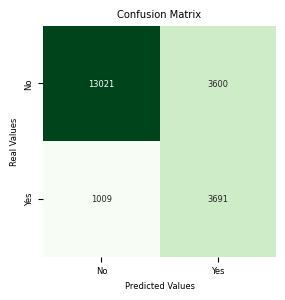

Accuracy: 0.784
Precision: 0.506
Recall: 0.785
F1 Score: 0.616


In [139]:
evaluate_predictions(y_test, y_test_pred)

---

In [141]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [150]:
# Define probability distribution of the hyperparameters to evaluate.
msl_val = (5, 10)
msl_prob = (0.6, 0.4)
msl_dist = rv_discrete(values=(msl_val, msl_prob))

mln_val = (10, 20, 30)
mln_prob = (0.35, 0.35, 0.3)
mln_dist = rv_discrete(values=(mln_val, mln_prob))

lr_val = (0.003, 0.01, 0.03)
lr_prob = (1/3, 1/3, 1/3)
lr_dist = rv_discrete(values=(lr_val, lr_prob))

ntrees_val = (60, 80, 100)
ntrees_prob = (0.45, 0.45, 0.1)
ntrees_dist = rv_discrete(values=(ntrees_val, ntrees_prob))

subs_val = (0.6, 0.8, 1)
subs_prob = (0.2, 0.3, 0.5)
subs_dist = rv_discrete(values=(subs_val, subs_prob))

# Use CV to find the optimal hyperparameters and train the validation model.
gbc_base = GradientBoostingClassifier(max_depth=None, random_state=random_seed)

parameters = {
    "min_samples_leaf": msl_dist,
    "max_leaf_nodes": mln_dist,
    "learning_rate": lr_dist,
    "n_estimators": ntrees_dist,
    "subsample": subs_dist,
}

gbc_search = RandomizedSearchCV(
    estimator=hgbr_base,
    param_distributions=parameters,
    n_iter=10,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    random_state=42,
)
gbc_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=3,
                   estimator=GradientBoostingClassifier(max_depth=None,
                                                        random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_sample object at 0x0000018D4B6139D0>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_sample object at 0x0000018D6F1FC9D0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_sample object at 0x0000018D4B632260>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_sample object at 0x0000018D6F1FF6A0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_sample object at 0x0000018D4B631A80>},
                   random_state=42, scoring='f1')

In [151]:
gbc_search.best_params_

{'learning_rate': 0.03,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 5,
 'n_estimators': 80,
 'subsample': 0.6}

In [154]:
gbc_final = GradientBoostingClassifier(
    **hgbr_search.best_params_, random_state=random_seed
)

gbc_final.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(learning_rate=0.03, max_leaf_nodes=10,
                           min_samples_leaf=5, n_estimators=80, random_state=42,
                           subsample=0.6)

---

#### Model Evaluation

In [156]:
y_test_pred = gbc_final.predict(X_test)

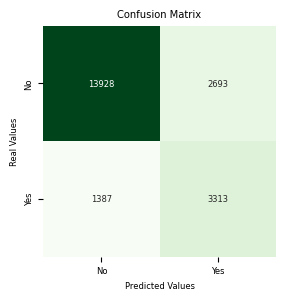

Accuracy: 0.809
Precision: 0.552
Recall: 0.705
F1 Score: 0.619


In [157]:
evaluate_predictions(y_test, y_test_pred)